In [1]:
%load_ext autoreload
%autoreload 2

In [146]:
import cv2
import numpy as np
from utils import *
from extractor import Extractor
import matplotlib.pyplot as plt
from transformation import *
from ransac import *


In [147]:
fe=Extractor()

In [148]:

def process_img(img,depth):
    matches=fe.extract(img,depth)
    # ransac(matches)
    # print(matches[:-1][0])
    
    # projected_map(matches,depth)
    for kp1,kp2 in matches:
        u1,v1,_=map(lambda x: int(round(x)),kp1)
        u2,v2,_=map(lambda x: int(round(x)),kp2)
        cv2.circle(img,(u1,v1),color=(0,255,0),radius=3)
        cv2.line(img,(u1,v1),(u2,v2),color=(255,0,0))
        disp(img,"RGB")




In [149]:
if __name__ == "__main__":
    
    depth_paths='../rgbd_dataset_freiburg1_xyz/depth.txt'
    dlist=data(depth_paths)

    rgb_paths='../rgbd_dataset_freiburg1_xyz/rgb.txt'
    ilist=data(rgb_paths)

    dataset_path='../rgbd_dataset_freiburg1_xyz/'
    

    for i in range(len(dlist)):

        frame=cv2.imread(dataset_path+ilist[i])
        depth=cv2.imread(dataset_path+dlist[i],0)
        # print(frame.shape,depth.shape)


        process_img(frame,depth)
        # print(frame)

        if frame is None:
            print("End of frame")
            break

        
        disp(depth,"Depth")
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()


        


In [89]:
th=np.pi*0/180.0

# R1=np.array([[np.cos(th),-np.sin(th),0],
#             [np.sin(th),np.cos(th),0],
#             [0,0,1]])
R1=np.array([[np.cos(th),-np.sin(th)],
            [np.sin(th),np.cos(th)]])
            

c1=1
t1=np.array([100,0]).T

# kp1=np.array([[1,2,3],[5,6,7]])
kp1=50*np.random.rand(2,100)




matches=[]
for i in range(kp1.shape[1]):
    k1=kp1[:,i]
    # k1 = tuple(k1)
    noise=np.random.rand(2)
    k2=c1*np.dot(R1,kp1[:,i])+t1+noise
    # print(k2.shape,noise.shape)
    # k2 = tuple(k2)
    matches.append((k1,k2))

# print(matches)




# params=ransac(matches)
# print(params['c'])



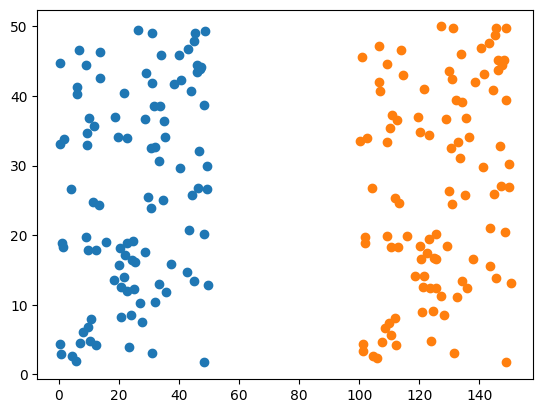

In [90]:
coordinate_array=np.array(matches)
kp1=coordinate_array[:,0,:].T
kp2=coordinate_array[:,1,:].T

plt.scatter(kp1[0,:],kp1[1,:])
plt.scatter(kp2[0,:],kp2[1,:])
plt.show()

T=Transformation()
T.compute_parameter(kp1,kp2)
error=T.error(kp1,kp2)
# print(error)

In [7]:
R2=params['R']
t2=params['t']
c2=params['c']


matches2=[]

for i in range(kp1.shape[1]):
    k1=kp1[:,i]
    k1 = tuple(k1)
    k2=c2*np.dot(R2,kp1[:,i])+t2
    k2 = tuple(k2)
    matches2.append((k1,k2))
print(R2)

[[ 8.66025404e-01 -5.00000000e-01  3.32589284e-16]
 [ 5.00000000e-01  8.66025404e-01  3.65068883e-16]
 [-4.56226080e-16  7.97984205e-16  1.00000000e+00]]


In [93]:
ransac=RANSAC(matches,T,3,0.5,100)
best_params,best_inlier,error=ransac.solve()


In [103]:
R2=best_params['R']
t2=best_params['t']
c2=best_params['c']

matches2=np.array(matches)

matches2=matches2[best_inlier]

print(np.sum(best_inlier))
# matches2=[]
# for i in range(kp1.shape[1]):
#     k1=kp1[:,i]
#     # k1 = tuple(k1)
#     noise=np.random.rand(2)
#     k2=c2*np.dot(R2,kp1[:,i])+t2.reshape(2)
#     # print(k2.shape,t2.shape)
#     # k2 = tuple(k2)
#     matches2.append((k1,k2))


80


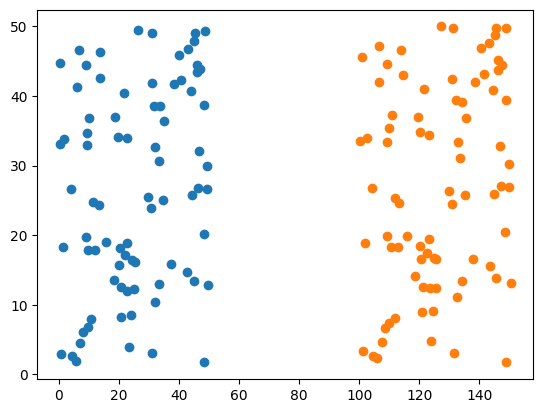

In [102]:
coordinate_array=np.array(matches2)
kp1=coordinate_array[:,0,:].T
kp2=coordinate_array[:,1,:].T

plt.scatter(kp1[0,:],kp1[1,:])
plt.scatter(kp2[0,:],kp2[1,:])
plt.show()

In [96]:
print(best_params)

{'R': array([[ 0.9999963 , -0.00271925],
       [ 0.00271925,  0.9999963 ]]), 't': array([[100.46905313],
       [  0.23909838]]), 'c': 1.0049971540656797}
